### [문제 1] Fashion MNIST 데이터 정규화를 위한 Mean과 Std. 값 찾기

In [3]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import transforms

import os

In [4]:
BASE_PATH = "."
data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

CHECKPOINT_FILE_PATH = os.path.join(BASE_PATH, "checkpoints")
if not os.path.isdir(CHECKPOINT_FILE_PATH):
  os.makedirs(os.path.join(BASE_PATH, "checkpoints"))

f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

In [5]:
import torch
from torch import nn, optim

In [6]:
imgs = torch.stack([img_t for img_t, _ in f_mnist_train], dim=3)
mean = imgs.view(1, -1).mean(dim=-1)
std = imgs.view(1, -1).std(dim=-1)
print(mean, std, sep='\n')

tensor([0.2862])
tensor([0.3530])


### [문제 2] Fashion MNIST 데이터에 대하여 CNN 학습시키기

In [10]:
import wandb

from datetime import datetime
from torchinfo import summary

In [12]:
def get_fashion_mnist_data():
  data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

  f_mnist_train = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())
  f_mnist_train, f_mnist_validation = random_split(f_mnist_train, [55_000, 5_000])

  print("Num Train Samples: ", len(f_mnist_train))
  print("Num Validation Samples: ", len(f_mnist_validation))
  print("Sample Shape: ", f_mnist_train[0][0].shape)  # torch.Size([1, 28, 28])

  train_data_loader = DataLoader(
    dataset=f_mnist_train, batch_size=wandb.config.batch_size,
    shuffle=True, pin_memory=True
  )

  validation_data_loader = DataLoader(
    dataset=f_mnist_validation, batch_size=wandb.config.batch_size,
    pin_memory=True
  )

  f_mnist_transforms = nn.Sequential(
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=mean, std=std),
  )

  return train_data_loader, validation_data_loader, f_mnist_transforms

In [13]:
def get_fashion_mnist_test_data():
  data_path = os.path.join(BASE_PATH, "_00_data", "j_fashion_mnist")

  f_mnist_test_images = datasets.FashionMNIST(data_path, train=False, download=True)
  f_mnist_test = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())

  print("Num Test Samples: ", len(f_mnist_test))
  print("Sample Shape: ", f_mnist_test[0][0].shape)  # torch.Size([1, 28, 28])

  test_data_loader = DataLoader(dataset=f_mnist_test, batch_size=len(f_mnist_test))

  f_mnist_transforms = nn.Sequential(
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=mean, std=std),
  )

  return f_mnist_test_images, test_data_loader, f_mnist_transforms

In [18]:
def get_my_model():
    class MyVGGModel(nn.Module):
        def __init__(self, in_channels, n_output):
            super(MyVGGModel, self).__init__()

            self.normalize = nn.BatchNorm2d(in_channels, eps=1e-5, momentum=0.1)

            self.features = nn.Sequential(
                nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),

                nn.Conv2d(64, 128, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),

                nn.Conv2d(128, 256, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(256, 256, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
            )

            self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

            self.classifier = nn.Sequential(
                nn.Linear(256 * 7 * 7, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(0.5),
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(0.5),
                nn.Linear(4096, n_output)
            )

        def forward(self, x):
            x = self.features(x)
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.classifier(x)
            return x

    my_model = MyVGGModel(in_channels=1, n_output=10)
    return my_model

In [14]:
from string import Template

class DeltaTemplate(Template):
    delimiter = "%"

    def strfdelta(tdelta, fmt):
        d = {"D": tdelta.days}
        d["H"], rem = divmod(tdelta.seconds, 3600)
        d["M"], d["S"] = divmod(rem, 60)
        t = DeltaTemplate(fmt)
        return t.substitute(**d)

def strfdelta(td, fmt):

    # Get the timedelta’s sign and absolute number of seconds.
    sign = "-" if td.days < 0 else "+"
    secs = abs(td).total_seconds()

    # Break the seconds into more readable quantities.
    days, rem = divmod(secs, 86400)  # Seconds per day: 24 * 60 * 60
    hours, rem = divmod(rem, 3600)  # Seconds per hour: 60 * 60
    mins, secs = divmod(rem, 60)

    # Format (as per above answers) and return the result string.
    t = DeltaTemplate(fmt)
    return t.substitute(
        s=sign,
        D="{:d}".format(int(days)),
        H="{:02d}".format(int(hours)),
        M="{:02d}".format(int(mins)),
        S="{:02d}".format(int(secs)),
        )

In [15]:
class EarlyStopping:
  """Early stops the training if validation loss doesn't improve after a given patience."""
  def __init__(self, patience=10, delta=0.00001, project_name=None, checkpoint_file_path=None, run_time_str=None):
    self.patience = patience
    self.counter = 0
    self.delta = delta

    self.val_loss_min = None
    self.file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_{run_time_str}.pt"
    )
    self.latest_file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
    )

  def check_and_save(self, new_validation_loss, model):
    early_stop = False

    if self.val_loss_min is None:
      self.val_loss_min = new_validation_loss
      message = f'Early stopping is stated!'
    elif new_validation_loss < self.val_loss_min - self.delta:
      message = f'V_loss decreased ({self.val_loss_min:7.5f} --> {new_validation_loss:7.5f}). Saving model...'
      self.save_checkpoint(new_validation_loss, model)
      self.val_loss_min = new_validation_loss
      self.counter = 0
    else:
      self.counter += 1
      message = f'Early stopping counter: {self.counter} out of {self.patience}'
      if self.counter >= self.patience:
        early_stop = True
        message += " *** TRAIN EARLY STOPPED! ***"

    return message, early_stop

  def save_checkpoint(self, val_loss, model):
    '''Saves model when validation loss decrease.'''
    torch.save(model.state_dict(), self.file_path)
    torch.save(model.state_dict(), self.latest_file_path)
    self.val_loss_min = val_loss


class ClassificationTrainer:
  def __init__(
    self, project_name, model, optimizer, train_data_loader, validation_data_loader, transforms,
    run_time_str, wandb, device, checkpoint_file_path
  ):
    self.project_name = project_name
    self.model = model
    self.optimizer = optimizer
    self.train_data_loader = train_data_loader
    self.validation_data_loader = validation_data_loader
    self.transforms = transforms
    self.run_time_str = run_time_str
    self.wandb = wandb
    self.device = device
    self.checkpoint_file_path = checkpoint_file_path

    # Use a built-in loss function
    self.loss_fn = nn.CrossEntropyLoss()

  def do_train(self):
    self.model.train()  # Explained at 'Diverse Techniques' section

    loss_train = 0.0
    num_corrects_train = 0
    num_trained_samples = 0
    num_trains = 0

    for train_batch in self.train_data_loader:
      input_train, target_train = train_batch
      input_train = input_train.to(device=self.device)
      target_train = target_train.to(device=self.device)

      if self.transforms:
        input_train = self.transforms(input_train)

      output_train = self.model(input_train)

      loss = self.loss_fn(output_train, target_train)
      loss_train += loss.item()

      predicted_train = torch.argmax(output_train, dim=1)
      num_corrects_train += torch.sum(torch.eq(predicted_train, target_train)).item()

      num_trained_samples += len(input_train)
      num_trains += 1

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

    train_loss = loss_train / num_trains
    train_accuracy = 100.0 * num_corrects_train / num_trained_samples

    return train_loss, train_accuracy

  def do_validation(self):
    self.model.eval()   # Explained at 'Diverse Techniques' section

    loss_validation = 0.0
    num_corrects_validation = 0
    num_validated_samples = 0
    num_validations = 0

    with torch.no_grad():
      for validation_batch in self.validation_data_loader:
        input_validation, target_validation = validation_batch
        input_validation = input_validation.to(device=self.device)
        target_validation = target_validation.to(device=self.device)

        if self.transforms:
          input_validation = self.transforms(input_validation)

        output_validation = self.model(input_validation)
        loss_validation += self.loss_fn(output_validation, target_validation).item()

        predicted_validation = torch.argmax(output_validation, dim=1)
        num_corrects_validation += torch.sum(torch.eq(predicted_validation, target_validation)).item()

        num_validated_samples += len(input_validation)
        num_validations += 1

    validation_loss = loss_validation / num_validations
    validation_accuracy = 100.0 * num_corrects_validation / num_validated_samples

    return validation_loss, validation_accuracy

  def train_loop(self):
    early_stopping = EarlyStopping(
      patience=self.wandb.config.early_stop_patience,
      delta=self.wandb.config.early_stop_delta,
      project_name=self.project_name,
      checkpoint_file_path=self.checkpoint_file_path,
      run_time_str=self.run_time_str
    )
    n_epochs = self.wandb.config.epochs
    training_start_time = datetime.now()

    for epoch in range(1, n_epochs + 1):
      train_loss, train_accuracy = self.do_train()

      if epoch == 1 or epoch % self.wandb.config.validation_intervals == 0:
        validation_loss, validation_accuracy = self.do_validation()

        elapsed_time = datetime.now() - training_start_time
        epoch_per_second = 0 if elapsed_time.seconds == 0 else epoch / elapsed_time.seconds

        message, early_stop = early_stopping.check_and_save(validation_loss, self.model)

        print(
          f"[Epoch {epoch:>3}] "
          f"T_loss: {train_loss:7.5f}, "
          f"T_accuracy: {train_accuracy:6.4f} | "
          f"V_loss: {validation_loss:7.5f}, "
          f"V_accuracy: {validation_accuracy:6.4f} | "
          f"{message} | "
          f"T_time: {strfdelta(elapsed_time, '%H:%M:%S')}, "
          f"T_speed: {epoch_per_second:4.3f}"
        )

        self.wandb.log({
          "Epoch": epoch,
          "Training loss": train_loss,
          "Training accuracy (%)": train_accuracy,
          "Validation loss": validation_loss,
          "Validation accuracy (%)": validation_accuracy,
          "Training speed (epochs/sec.)": epoch_per_second,
        })

        if early_stop:
          break

    elapsed_time = datetime.now() - training_start_time
    print(f"Final training time: {strfdelta(elapsed_time, '%H:%M:%S')}")

class ClassificationTester:
  def __init__(self, project_name, model, test_data_loader, transforms, checkpoint_file_path):
    self.project_name = project_name
    self.model = model
    self.test_data_loader = test_data_loader
    self.transforms = transforms

    self.latest_file_path = os.path.join(
      checkpoint_file_path, f"{project_name}_checkpoint_latest.pt"
    )

    print("MODEL FILE: {0}".format(self.latest_file_path))

    self.model.load_state_dict(torch.load(self.latest_file_path, map_location=torch.device('cpu')))

  def test(self):
    self.model.eval()    # Explained at 'Diverse Techniques' section

    num_corrects_test = 0
    num_tested_samples = 0

    with torch.no_grad():
      for test_batch in self.test_data_loader:
        input_test, target_test = test_batch

        input_test = self.transforms(input_test)

        output_test = self.model(input_test)

        predicted_test = torch.argmax(output_test, dim=1)
        num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

        num_tested_samples += len(input_test)

      test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

  def test_single(self, input_test):
    self.model.eval()    # Explained at 'Diverse Techniques' section

    with torch.no_grad():
      input_test = self.transforms(input_test)

      output_test = self.model(input_test)
      predicted_test = torch.argmax(output_test, dim=1)

    return predicted_test.item()

In [25]:
if __name__ == "__main__":
  config = {
      'epochs': 3_000,
      'batch_size': 1024,
      'validation_intervals': 10,
      'learning_rate': 1e-3,
      'early_stop_patience': 5,
      'early_stop_delta': 0.00001,
      'weight_decay': 1e-4
  }

  project_name = "cnn_mnist_fashion"
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
  wandb.init(
      mode="online",
      project=project_name,
      name=run_time_str,
      config=config
  )
  print(wandb.config)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  train_data_loader, validation_data_loader, f_mnist_transforms = get_fashion_mnist_data()
  print()
  f_mnist_test_images, test_data_loader, f_mnist_transforms = get_fashion_mnist_test_data()

  model = get_my_model()
  model.to(device)
  wandb.watch(model)

  from torchinfo import summary
  print(summary(model=model, input_size=(1, 1, 28, 28)))

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=config['weight_decay'])

  classification_trainer = ClassificationTrainer(
      project_name, model, optimizer, train_data_loader, validation_data_loader, f_mnist_transforms,
      run_time_str, wandb, device, CHECKPOINT_FILE_PATH
  )
  classification_trainer.train_loop()

  wandb.finish()

{'epochs': 3000, 'batch_size': 1024, 'validation_intervals': 10, 'learning_rate': 0.001, 'early_stop_patience': 5, 'early_stop_delta': 1e-05, 'weight_decay': 0.0001}
Num Train Samples:  55000
Num Validation Samples:  5000
Sample Shape:  torch.Size([1, 28, 28])

Num Test Samples:  10000
Sample Shape:  torch.Size([1, 28, 28])
Layer (type:depth-idx)                   Output Shape              Param #
MyVGGModel                               [1, 10]                   2
├─Sequential: 1-1                        [1, 256, 3, 3]            --
│    └─Conv2d: 2-1                       [1, 64, 28, 28]           640
│    └─ReLU: 2-2                         [1, 64, 28, 28]           --
│    └─Conv2d: 2-3                       [1, 64, 28, 28]           36,928
│    └─ReLU: 2-4                         [1, 64, 28, 28]           --
│    └─MaxPool2d: 2-5                    [1, 64, 14, 14]           --
│    └─Conv2d: 2-6                       [1, 128, 14, 14]          73,856
│    └─ReLU: 2-7               

Epoch,▁▂▃▄▆▇█
Training accuracy (%),▁▇█████
Training loss,█▂▁▁▁▁▁
Training speed (epochs/sec.),▁▆▆▇▇██
Validation accuracy (%),▁██████
Validation loss,█▁▂▃▄▄▄
Epoch,60
Training accuracy (%),99.39273
Training loss,0.01773
Training speed (epochs/sec.),0.17964
Validation accuracy (%),92.52


#### 하이퍼파라미터 제시
Learning Rate 0.001  
Batch Size 1024  
Early Stop Patience 5  
Weight Decay Value 0.0001  
Normalization Type 배치(eps=1e-5, momentum=0.1)  
Dropout Rate FC 레이어간 0.5  

#### Wandb URL
https://wandb.ai/sapigr/cnn_mnist_fashion?workspace=user-impulsivegr99

### [문제 3] 학습 완료된 모델로 테스트 데이터 Accuracy 확인하기

In [27]:
test_model = get_my_model()
classification_tester = ClassificationTester(
"cnn_mnist_fashion", test_model, test_data_loader, f_mnist_transforms, CHECKPOINT_FILE_PATH
)
classification_tester.test()

MODEL FILE: .\checkpoints\cnn_mnist_fashion_checkpoint_latest.pt
TEST RESULTS: 91.710%


### [문제 4] 샘플 테스트 데이터 분류 예측 결과 확인하기

In [76]:
import numpy as np
from matplotlib import pyplot as plt

labels = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

LABEL: Ankle boot / PREDICTION: Ankle boot


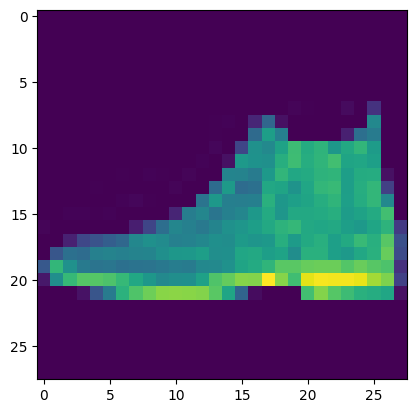

LABEL: Pullover / PREDICTION: Pullover


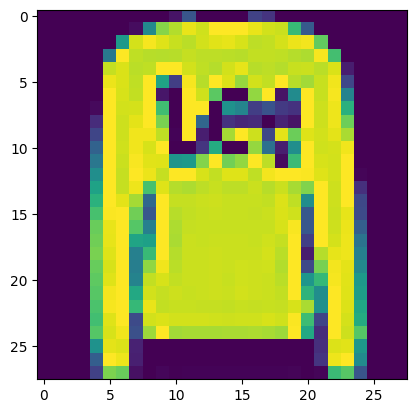

LABEL: Trouser / PREDICTION: Trouser


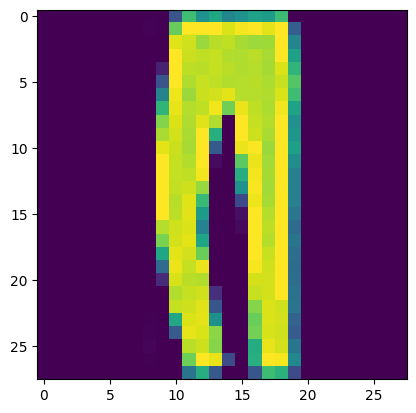

LABEL: Trouser / PREDICTION: Trouser


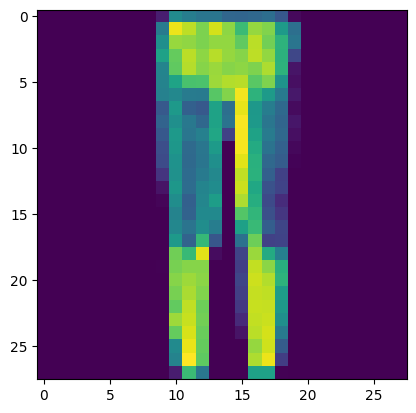

LABEL: Shirt / PREDICTION: Shirt


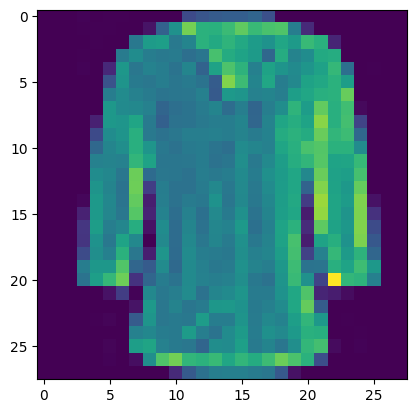

LABEL: Trouser / PREDICTION: Trouser


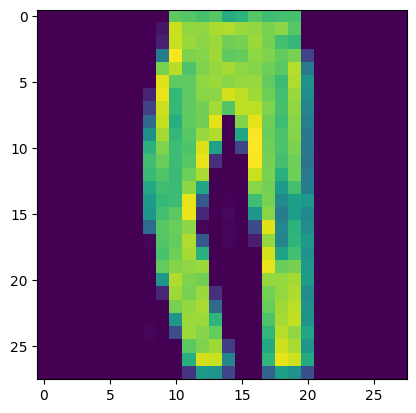

LABEL: Coat / PREDICTION: Coat


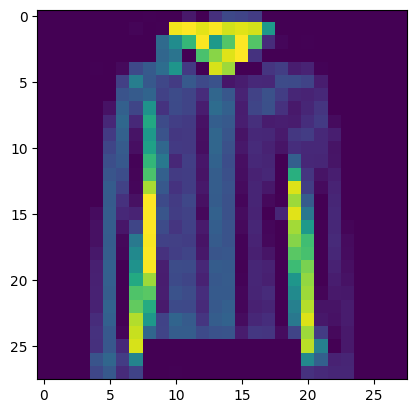

LABEL: Shirt / PREDICTION: Shirt


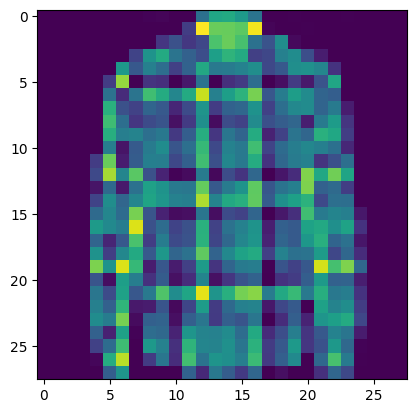

LABEL: Sandal / PREDICTION: Sandal


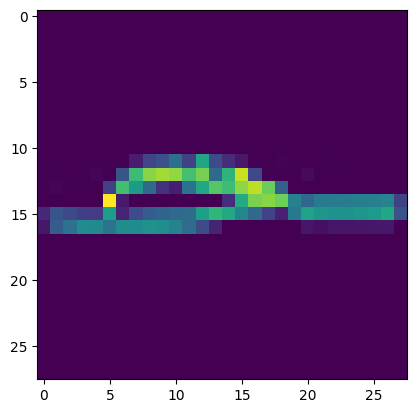

LABEL: Sneaker / PREDICTION: Sneaker


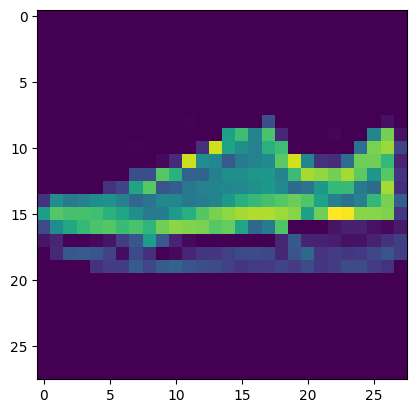

In [77]:
matchCount = 10
for img, label in f_mnist_test_images:
    output = classification_tester.test_single(torch.tensor(np.array(img)).unsqueeze(dim=0).unsqueeze(dim=0))
    if label == output:
        print(f"LABEL: {labels[label]} / PREDICTION: {labels[output]}")
        plt.imshow(img); plt.show();
        matchCount -= 1
    if matchCount <= 0: break

LABEL: Sneaker / PREDICTION: Sandal


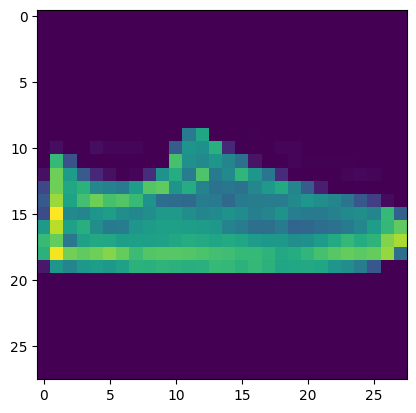

LABEL: Coat / PREDICTION: Shirt


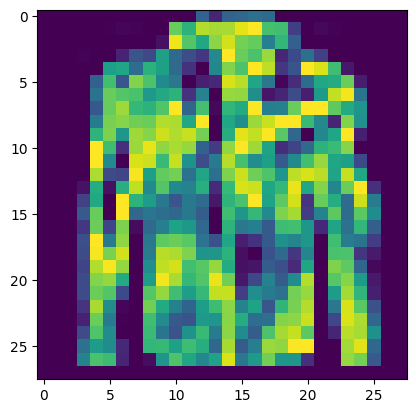

LABEL: Coat / PREDICTION: Pullover


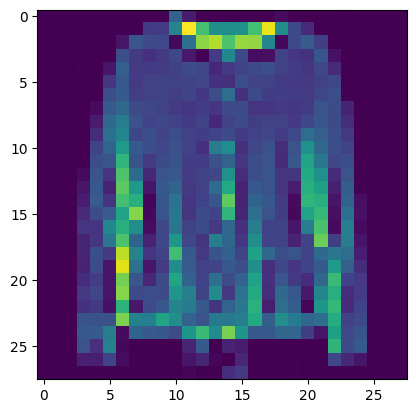

LABEL: Dress / PREDICTION: Coat


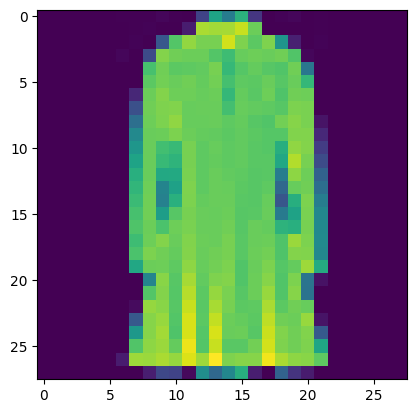

LABEL: Dress / PREDICTION: Trouser


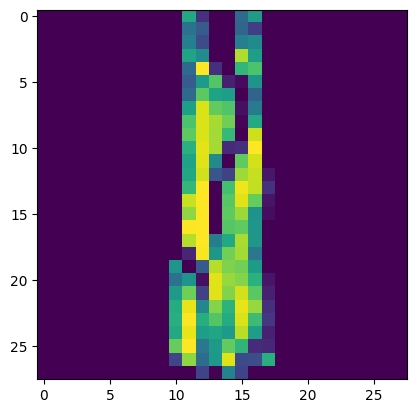

LABEL: Dress / PREDICTION: T-shirt/top


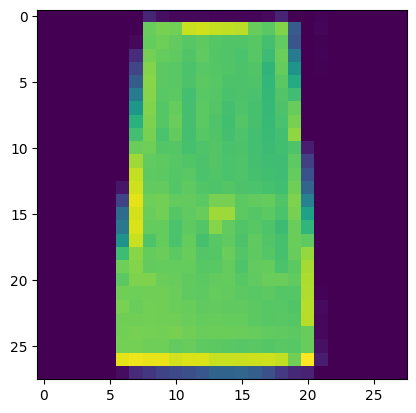

LABEL: Pullover / PREDICTION: Shirt


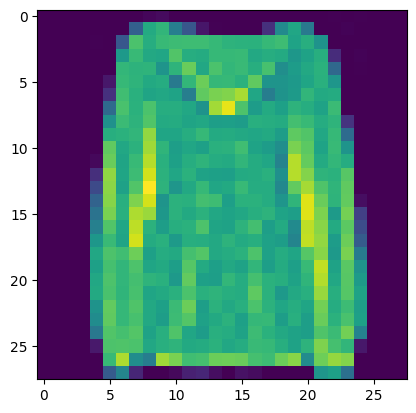

LABEL: Dress / PREDICTION: Coat


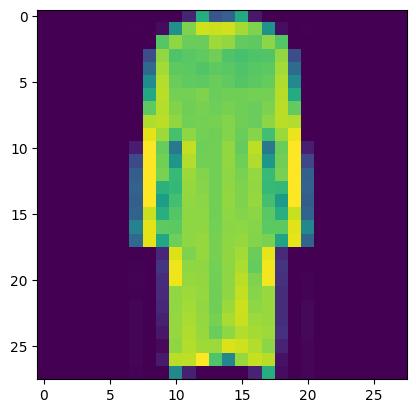

LABEL: Ankle boot / PREDICTION: Sneaker


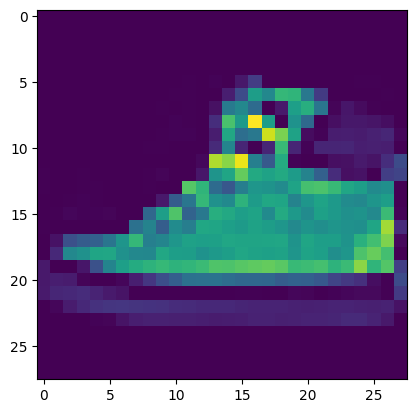

LABEL: Coat / PREDICTION: Pullover


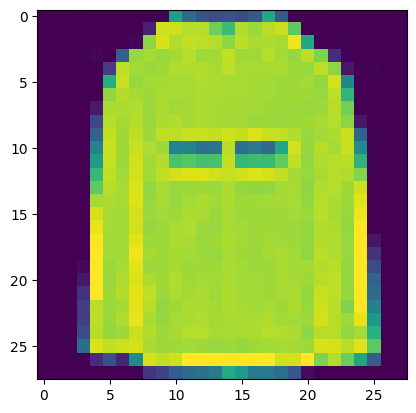

In [78]:
misMatchCount = 10
for img, label in f_mnist_test_images:
    output = classification_tester.test_single(torch.tensor(np.array(img)).unsqueeze(dim=0).unsqueeze(dim=0))
    if label != output:
        print(f"LABEL: {labels[label]} / PREDICTION: {labels[output]}")
        plt.imshow(img); plt.show();
        misMatchCount -= 1
    if misMatchCount <= 0: break

#### 예측결과가 틀린 이유?  
Sneaker와 Dress는 명확히 틀린것 같지만  
다른 이미지들은 직접 이미지를 봤을때 구분이 어렵긴 하다.  
몇개는 PREDICTION보다 LABEL이 틀린것처럼 느껴진다.  
다른 샘플들과 비교했을때 LABEL이 일관성이 없거나,  
또는 데이터 증강을 사용하지않아 편향되어 있을 수 있다.

#### [숙제후기]  
과제를 수행하며 수업때 배운 최적화 방법을 사용하며 비교해봤습니다.  
Adam Optimizer와 L2 Regularization이 가장 효과가 눈에 띄었습니다.  
예측결과를 확인해보니 Data Augmentation을 사용해봤다면 정확도를 더 높일수 있지 않았을까 싶습니다.  

학습에는 VGG 모델을 참고하여 구성하였는데 EPOCH가 지날때마다 값이 크게 오릅니다.  
과적합이 발생하는것 같아 WeightDecay, Dropout 값을 조정해봤는데 왜인지 눈에 띄는 효과는 없었습니다.  
심플한 모델을 사용했을때와 비교해도 정확도가 높지만 만족스럽지는 않습니다.